# Table of Contents
* [Import data and Recover the 5-Fold Validation Indices](#Import-data-and-Recover-the-5-Fold-Validation-Indices)
* [Function to log results](#Function-to-log-results)
* [Use CountVectorizer to create feature matrix](#Use-CountVectorizer-to-create-feature-matrix)
* [Classification Models](#Classification-Models)
    * [1.1 RandomForest](#1.1-RandomForest)
    * [1.2 Multinomial Naive Bayes](#1.2-Multinomial-Naive-Bayes)
    * [1.3 LightGBM](#1.3-LightGBM)
    * [1.4 Logistic Regression with regularizations](#1.4-Logistic-Regression-with-regularizations)
* [Summary of models](#Summary-of-models)

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm
#!pip install afinn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.python.keras import models, layers, optimizers
#import tensorflow
#from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
#from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
%matplotlib inline
# Training and Testing data files are available in the "../python notebook v1" directory.
# The following function finds all the .csv files in the project directory
import os
#def find_csv_filenames(path_to_dir, suffix=".csv"):
#    filenames = os.listdir(path_to_dir)
#    return [filename for filename in filenames if filename.endswith(suffix)]
#filenames = find_csv_filenames("../python notebook v1")
#for name in filenames:
#    print(name)

pd.options.display.max_colwidth = 200
import statistics
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns
import sklearn
import sqlite3
from sqlite3 import Error
import csv
import lightgbm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Function to log results

In [4]:
def model_log(cv_clf, modelname):
    rlt_dict = {}

    rlt_dict['best_estimator_'] = [cv_clf.best_estimator_]
    rlt_dict['best_params_'] = [cv_clf.best_params_]
    rlt_dict['best_score_'] = [cv_clf.best_score_]
    rlt_dict['best_index_'] = [cv_clf.best_index_]

    rlt_dict['candidate_params'] = [cv_clf.cv_results_['params']]
    rlt_dict['mean_test_score'] = [cv_clf.cv_results_['mean_test_score']]
    rlt_dict['std_test_score'] = [cv_clf.cv_results_['std_test_score']]
    rlt_dict['mean_train_score'] = [cv_clf.cv_results_['mean_train_score']]
    rlt_dict['std_train_score'] = [cv_clf.cv_results_['std_train_score']]

    rlt_dict['split0_test_score'] = [cv_clf.cv_results_['split0_test_score']]
    rlt_dict['split1_test_score'] = [cv_clf.cv_results_['split1_test_score']]
    rlt_dict['split2_test_score'] = [cv_clf.cv_results_['split2_test_score']]
    rlt_dict['split3_test_score'] = [cv_clf.cv_results_['split3_test_score']]
    rlt_dict['split4_test_score'] = [cv_clf.cv_results_['split4_test_score']]

    rlt_dict['split0_train_score'] = [cv_clf.cv_results_['split0_train_score']]
    rlt_dict['split1_train_score'] = [cv_clf.cv_results_['split1_train_score']]
    rlt_dict['split2_train_score'] = [cv_clf.cv_results_['split2_train_score']]
    rlt_dict['split3_train_score'] = [cv_clf.cv_results_['split3_train_score']]
    rlt_dict['split4_train_score'] = [cv_clf.cv_results_['split4_train_score']]

    rlt_df = pd.DataFrame.from_dict(rlt_dict)
    
    filename = modelname + '_' + 'cv_rlt.csv'
    rlt_df.to_csv(filename)

## Import data and Recover the 5-Fold Validation Indices

In [5]:
X_train = pd.read_csv("X_train.csv", )
y_train_0 = pd.read_csv("y_train.csv", header=None)
y_train = y_train_0[0]
X_test = pd.read_csv("X_test.csv", )
y_test_0 = pd.read_csv("y_test.csv", header=None)
y_test = y_test_0[0]

In [6]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (11640, 9)
y_train shape:  (11640,)
X_test shape:  (2911, 9)
y_test shape:  (2911,)


In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=123, shuffle=True)
kf.get_n_splits(X_train)

5

In [8]:
i = 1
for train_index, val_index in kf.split(X_train):
    print(f"Fold {i}: ", "Train:", train_index, "Validation:", val_index)
    i = i + 1

Fold 1:  Train: [    0     1     2 ... 11636 11638 11639] Validation: [    3     6     7 ... 11619 11620 11637]
Fold 2:  Train: [    1     3     5 ... 11637 11638 11639] Validation: [    0     2     4 ... 11591 11624 11629]
Fold 3:  Train: [    0     1     2 ... 11637 11638 11639] Validation: [    8    33    35 ... 11631 11635 11636]
Fold 4:  Train: [    0     2     3 ... 11636 11637 11638] Validation: [    1     5    18 ... 11632 11634 11639]
Fold 5:  Train: [    0     1     2 ... 11636 11637 11639] Validation: [   13    16    17 ... 11628 11633 11638]


## Use CountVectorizer to create feature matrix

In [9]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Create CountVectoroizer object
vectorizer = CountVectorizer()
# Generate matrix of word vectors
X_train_matrix = vectorizer.fit_transform(X_train.text)
X_test_matrix = vectorizer.transform(X_test.text)

In [10]:
# Convert X_train_matrix into a DataFrame
X_train_df = pd.DataFrame(X_train_matrix.toarray())
# Map the column names to vocabulary 
X_train_df.columns = vectorizer.get_feature_names()
# keep the original ID column
X_train_df['ID'] = X_train.ID.to_list()
print(X_train_df.shape)
display(X_train_df.head())

(11640, 7028)


,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,zambia,zcc,zero,zipper,zone,zoom,zuke,zurich,zz,ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7908
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,538
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4501
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13982
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6048


Make sure after CountVectorizer, each row still corresponds to the same observation in the original train/test dataset

In [11]:
print(X_train.text[0])
X_train_df.iloc[0,:][X_train_df.iloc[0,:] >= 1]

point u cancel flight flight dca airline already cancel flightle


airline        1
already        1
cancel         2
dca            1
flight         2
flightle       1
point          1
ID          7908
Name: 0, dtype: int64

In [12]:
print(X_train.text[2])
X_train_df.iloc[2,:][X_train_df.iloc[2,:] >= 1]

come get point buy rapid reward shopping site


buy            1
come           1
get            1
point          1
rapid          1
reward         1
shopping       1
site           1
ID          4501
Name: 2, dtype: int64

In [13]:
X_train_leftover = X_train.drop(['text'], axis=1)
#display(X_train_leftover.head())
#display(X_train_df.head())
#print("Check the length are equal", len(X_train_leftover) == len(X_train_df))

# Get the full features by merging the 2 dataframes
X_train_final = pd.merge(X_train_df, X_train_leftover, how='inner', on='ID')
print(X_train_final.shape)
display(X_train_final.head())

(11640, 7035)


,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,zurich,zz,ID,retweet_count,airline_company_American,airline_company_Delta,airline_company_Southwest,airline_company_US Airways,airline_company_United,airline_company_Virgin America
0,0,0,0,0,0,0,0,0,0,0,...,0,0,7908,0.0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,538,0.0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,4501,0.0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,13982,0.0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,6048,0.0,0,0,1,0,0,0


In [14]:
# Drop the ID column to prepare for fitting models
X_train_no_ID = X_train_final.drop(['ID'], axis=1)
display(X_train_no_ID.head())

,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,zuke,zurich,zz,retweet_count,airline_company_American,airline_company_Delta,airline_company_Southwest,airline_company_US Airways,airline_company_United,airline_company_Virgin America
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,0,1,0,0,0


## Classification Models

### 1.1 RandomForest

In [55]:
import time
start = time.process_time()

niter, verbose, random_state = [5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'max_depth': range(1,20)}

clf = RandomForestClassifier(random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=kf, n_iter=niter, return_train_score=True, 
                            verbose=verbose, n_jobs=-1) 
cv_clf.fit(X_train_no_ID, y_train)

print('completed in {} s'.format(time.process_time() - start))

# write out results
model_log(cv_clf, 'RF_CountVectorizer')

completed in 34.726754 s


In [15]:
import re
import ast
result = pd.read_csv('RF_CountVectorizer_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
print("2. Best number of trees and depth are: {} and {}".format(best_n, best_d))
best_score_rf = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score_rf)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'n_estimators': 400, 'max_depth': 18}, {'n_estimators': 100, 'max_depth': 17}, {'n_estimators': 100, 'max_depth': 14}, {'n_estimators': 300, 'max_depth': 6}, {'n_estimators': 200, 'max_depth': 10}]
2. Best number of trees and depth are: 400 and 18
3. Best average CV validation score is:  0.638487972508591
4. Average CV validation score:  [0.63848797 0.6371134  0.63213058 0.62989691 0.63006873]
5. Standard Deviation of CV validation score:  [0.0054511  0.00490067 0.00816196 0.00673509 0.00683732]
6. Average CV training score:  [0.6425043  0.64140893 0.63438574 0.62989691 0.63026203]
7. Standard Deviation of CV training score:  [0.00151261 0.00368728 0.00216765 0.00168377 0.00146458]
1st fold validation score:  [0.63530928 0.63445017 0.63101375 0.62843643 0.62843643]
2nd fold validation score:  [0.63745704 0.63745704 0.62972509 0.62800687 0.62843643]
3rd fold validation score:  [0.64690722 0.64647766 0.64561856 0.63960481 0.64003436]
4th fold validati

Classification performance on the entire training set

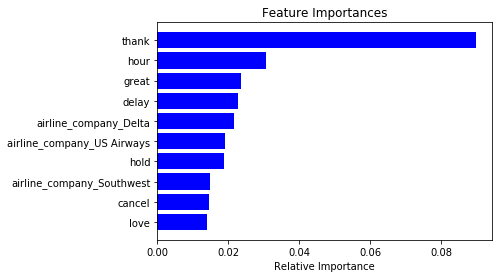

In [16]:
result = pd.read_csv('RF_CountVectorizer_cv_rlt.csv')
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']

clf = RandomForestClassifier(n_estimators = best_n, max_depth = best_d, 
                             bootstrap=True, class_weight=None, criterion='gini',
                             max_features='auto', max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_jobs=None,
                             oob_score=False, random_state=123, verbose=0, warm_start=False)

clf.fit(X_train_no_ID, y_train)

preds = clf.predict(X_train_no_ID)
probs = clf.predict_proba(X_train_no_ID)

# plot top 10 features of the training set
M = 10

importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train_no_ID.columns

plt.title('Feature Importances')
plt.barh(range(M), importances[indices][-M:], color='b', align='center')
plt.yticks(range(M), [features[i] for i in indices[-M:]])
plt.xlabel('Relative Importance')
plt.show()

In [17]:
#preds = clf.predict(X_train_no_ID)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train, preds, labels=None, sample_weight=None)
report = classification_report(y_train, preds)
#probs = clf.predict_proba(X_train_no_ID)
accuracy = float(np.sum(preds==y_train))/y_train.shape[0] 

print("1. Confusion Matrix for the training data is: \n", confusion_matrix)
print("2. Training accuracy: %f" % (accuracy))
print("3. Training report: ", report)

1. Confusion Matrix for the training data is: 
 [[ 109    0 2332]
 [   5   29 1833]
 [   9    0 7323]]
2. Training accuracy: 0.640979
3. Training report:                precision    recall  f1-score   support

           0       0.89      0.04      0.09      2441
           1       1.00      0.02      0.03      1867
           2       0.64      1.00      0.78      7332

   micro avg       0.64      0.64      0.64     11640
   macro avg       0.84      0.35      0.30     11640
weighted avg       0.75      0.64      0.51     11640



### 1.2 Multinomial Naive Bayes

Average training and validation scores show slight overfitting of the Naive Bayes algorithm

In [18]:
# Import MultinomialNB
from sklearn.naive_bayes import MultinomialNB # Create MultinomialNB object
clf = MultinomialNB()

# Train clf on 5 fold data
val_accuracy = []
train_acc = []
for train_index, val_index in kf.split(X_train):
    X_train_5cv, X_val_5cv = X_train_no_ID.iloc[train_index,:], X_train_no_ID.iloc[val_index,:]
    y_train_5cv, y_val_5cv = y_train[train_index], y_train[val_index]
    clf.fit(X_train_5cv, y_train_5cv)
    train_acc.append(clf.score(X_train_5cv, y_train_5cv))
    val_accuracy.append(clf.score(X_val_5cv, y_val_5cv))
print("5-Fold Training scores are: ", train_acc)
mean_train_score = np.mean(train_acc)
print("Average Training score is: {:.5f}".format(mean_train_score))
print("5-Fold Validation scores are: ", val_accuracy)
mean_validation_score_NB = np.mean(val_accuracy)
print("Average validation score is: {:.5f}".format(mean_validation_score_NB))

# write average validation score to csv file
rlt_dict = {}
rlt_dict['Average_val_score'] = [mean_validation_score_NB]
rlt_df = pd.DataFrame.from_dict(rlt_dict)
filename = "NB_CountVectorizer_cv_rlt.csv"
rlt_df.to_csv(filename)

5-Fold Training scores are:  [0.8393470790378007, 0.834729381443299, 0.8397766323024055, 0.8395618556701031, 0.8441795532646048]
Average Training score is: 0.83952
5-Fold Validation scores are:  [0.7628865979381443, 0.7658934707903781, 0.7598797250859106, 0.7697594501718213, 0.7439862542955327]
Average validation score is: 0.76048


Classification performance on the entire training set

In [19]:
clf = MultinomialNB()
clf.fit(X_train_no_ID, y_train)

# Compute accuracy on entire training set
train_accuracy = clf.score(X_train_no_ID, y_train) 
print("Training accuracy: %f" % (train_accuracy))

# create confusion matrix and classification report for the training data
preds = clf.predict(X_train_no_ID)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train, preds, labels=None, sample_weight=None)
report = classification_report(y_train, preds)
probs = clf.predict_proba(X_train_no_ID)
print("Confusion Matrix for training set is: \n", confusion_matrix)
print("Classification Report for training set is: \n", report)

Training accuracy: 0.838144
Confusion Matrix for training set is: 
 [[1424  122  895]
 [ 104 1378  385]
 [ 252  126 6954]]
Classification Report for training set is: 
               precision    recall  f1-score   support

           0       0.80      0.58      0.67      2441
           1       0.85      0.74      0.79      1867
           2       0.84      0.95      0.89      7332

   micro avg       0.84      0.84      0.84     11640
   macro avg       0.83      0.76      0.79     11640
weighted avg       0.84      0.84      0.83     11640



### 1.3 LightGBM

In [22]:
import time
start = time.process_time()

niter, verbose, random_state = [5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'learning_rate': [0.01,0.1,0.5], 
               'max_depth': range(1,5)}

clf = LGBMClassifier(colsample_bytree=1, subsample=1, reg_alpha=0, reg_lambda=1, verbose=verbose,
                     random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=kf, n_iter=niter, return_train_score=True, scoring='accuracy', 
                            verbose=verbose, n_jobs = -1)  
cv_clf.fit(X_train_no_ID, y_train)

print('completed in {} s'.format(time.process_time() - start))

# write out results
model_log(cv_clf, 'GBM_CountVectorizer')

completed in 8.624207902999999 s


In [23]:
import re
import ast
result = pd.read_csv('GBM_CountVectorizer_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
best_lr = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['learning_rate']
print("2. Best number of trees, learning rate and depth are: {}, {} and {}".format(best_n, best_lr, best_d))
best_score_LGB = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score_LGB)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1}, {'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.01}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1}, {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}, {'n_estimators': 400, 'max_depth': 1, 'learning_rate': 0.5}]
2. Best number of trees, learning rate and depth are: 400, 0.5 and 1
3. Best average CV validation score is:  0.7644329896907216
4. Average CV validation score:  [0.76065292 0.68582474 0.75945017 0.75635739 0.76443299]
5. Standard Deviation of CV validation score:  [0.00513599 0.00677333 0.00419997 0.00469296 0.00403506]
6. Average CV training score:  [0.78436426 0.68651203 0.78191581 0.77300258 0.79018471]
7. Standard Deviation of CV training score:  [0.00156507 0.00171606 0.00100372 0.00161068 0.00136919]
1st fold validation score:  [0.75687285 0.67482818 0.75773196 0.75257732 0.7628866 ]
2nd fold validation score:  [0.76718213 0.68685567 0.7628866

Classification performance on the entire training set

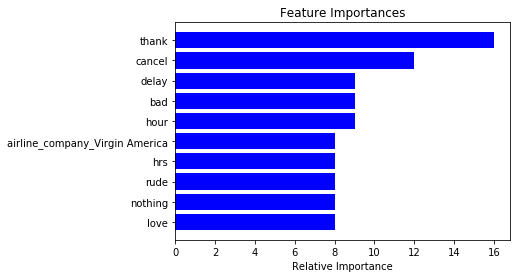

In [24]:
result = pd.read_csv('GBM_CountVectorizer_cv_rlt.csv')
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
best_lr = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['learning_rate']

clf = LGBMClassifier(n_estimators=best_n, learning_rate=best_lr, max_depth=best_d, 
                     boosting_type='gbdt', class_weight=None, colsample_bytree=1,
                     importance_type='split', min_child_samples=20, min_child_weight=0.001, 
                     min_split_gain=0.0, n_jobs=-1, num_leaves=31, objective=None, random_state=None, 
                     reg_alpha=0, reg_lambda=1, silent=True, subsample=1, subsample_for_bin=200000, 
                     subsample_freq=0, verbose=0)

clf.fit(X_train_no_ID, y_train)

preds = clf.predict(X_train_no_ID)
probs = clf.predict_proba(X_train_no_ID)

# plot top 10 features of the training set
M = 10
importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train_no_ID.columns

plt.title('Feature Importances')
plt.barh(range(M), importances[indices][-M:], color='b', align='center')
plt.yticks(range(M), [features[i] for i in indices[-M:]])
plt.xlabel('Relative Importance')
plt.show()

In [25]:
preds = clf.predict(X_train_no_ID)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train, preds, labels=None, sample_weight=None)
report = classification_report(y_train, preds)
probs = clf.predict_proba(X_train_no_ID)
accuracy = float(np.sum(preds==y_train))/y_train.shape[0] 

print("1. Confusion Matrix for the training data is: \n", confusion_matrix)
print("2. Training accuracy: %f" % (accuracy))
print("3. Training report: ", report)

1. Confusion Matrix for the training data is: 
 [[1128  177 1136]
 [ 201 1199  467]
 [ 310  163 6859]]
2. Training accuracy: 0.789175
3. Training report:                precision    recall  f1-score   support

           0       0.69      0.46      0.55      2441
           1       0.78      0.64      0.70      1867
           2       0.81      0.94      0.87      7332

   micro avg       0.79      0.79      0.79     11640
   macro avg       0.76      0.68      0.71     11640
weighted avg       0.78      0.79      0.78     11640



### 1.4 Logistic Regression with regularizations

In [26]:
import time
start = time.process_time()

niter, verbose, random_state = [5, 0, 123] 
param_space = {'penalty': ['l1','l2'], 'C': [0.005, 0.01, 0.1, 1, 10, 100, 200]}
        
clf = LogisticRegression(random_state=random_state, solver='saga', multi_class='multinomial')
cv_clf = RandomizedSearchCV(clf, param_space, cv=kf, n_iter=niter, return_train_score=True, scoring='accuracy', 
                            verbose=verbose, n_jobs = -1) 
cv_clf.fit(X_train_no_ID, y_train)

print('completed in {} s'.format(time.process_time() - start))

# write out results
model_log(cv_clf, 'logistic_CountVectorizer')

completed in 360.88216224999996 s


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [27]:
import re
import ast
result = pd.read_csv('logistic_CountVectorizer_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_c = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['C']
best_penalty = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['penalty']
print("2. Best C and penalty are: {} and {}".format(best_c, best_penalty))
best_score_Logistic = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score_Logistic)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'penalty': 'l2', 'C': 200}, {'penalty': 'l1', 'C': 10}, {'penalty': 'l2', 'C': 1}, {'penalty': 'l2', 'C': 0.005}, {'penalty': 'l2', 'C': 10}]
2. Best C and penalty are: 10 and l1
3. Best average CV validation score is:  0.7879725085910653
4. Average CV validation score:  [0.78453608 0.78797251 0.78402062 0.6967354  0.78462199]
5. Standard Deviation of CV validation score:  [0.0049097  0.00619272 0.00480178 0.00520451 0.00491721]
6. Average CV training score:  [0.84748711 0.86793385 0.8455756  0.70165378 0.84735825]
7. Standard Deviation of CV training score:  [0.00980554 0.01057814 0.00894951 0.00178717 0.00976433]
1st fold validation score:  [0.78479381 0.78694158 0.78608247 0.69501718 0.78522337]
2nd fold validation score:  [0.79209622 0.7959622  0.79166667 0.69630584 0.79209622]
3rd fold validation score:  [0.78522337 0.78994845 0.7830756  0.70274914 0.78522337]
4th fold validation score:  [0.78393471 0.78994845 0.78221649 0.68814433 0.78393471]


Classification performance on the entire training set, looks like there is overfitting

In [29]:
result = pd.read_csv('logistic_CountVectorizer_cv_rlt.csv')
best_c = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['C']
best_penalty = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['penalty']

clf = LogisticRegression(C=best_c, class_weight=None, dual=False, fit_intercept=True,
                         intercept_scaling=1, max_iter=100, solver='saga', multi_class='multinomial',
                         n_jobs=None, penalty=best_penalty, random_state=123, 
                         tol=0.0001, verbose=0, warm_start=False)
clf.fit(X_train_no_ID, y_train)

preds = clf.predict(X_train_no_ID)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train, preds, labels=None, sample_weight=None)
report = classification_report(y_train, preds)
probs = clf.predict_proba(X_train_no_ID)
accuracy = float(np.sum(preds==y_train))/y_train.shape[0] 

print("1. Confusion Matrix for the training data is: \n", confusion_matrix)
print("2. Training accuracy: %f" % (accuracy))
print("3. Training report: ", report)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1. Confusion Matrix for the training data is: 
 [[1680  142  619]
 [ 189 1423  255]
 [ 302  114 6916]]
2. Training accuracy: 0.860739
3. Training report:                precision    recall  f1-score   support

           0       0.77      0.69      0.73      2441
           1       0.85      0.76      0.80      1867
           2       0.89      0.94      0.91      7332

   micro avg       0.86      0.86      0.86     11640
   macro avg       0.84      0.80      0.82     11640
weighted avg       0.86      0.86      0.86     11640



## Summary of models

The best model selected based on average validation score

In [30]:
result = pd.read_csv('RF_CountVectorizer_cv_rlt.csv')
best_score_rf = result.best_score_.values[0]

result = pd.read_csv('NB_CountVectorizer_cv_rlt.csv')
mean_validation_score_NB = result.Average_val_score[0]

result = pd.read_csv('GBM_CountVectorizer_cv_rlt.csv')
best_score_LGB = result.best_score_.values[0]

result = pd.read_csv('logistic_CountVectorizer_cv_rlt.csv')
best_score_Logistic = result.best_score_.values[0]

validation_scores = {'RandomForest': best_score_rf, 'Naive Bayes': mean_validation_score_NB, 
                     'LightGBM': best_score_LGB, 'Logistic Regression': best_score_Logistic}
print(validation_scores)

{'RandomForest': 0.638487972508591, 'Naive Bayes': 0.7604810996563574, 'LightGBM': 0.7644329896907216, 'Logistic Regression': 0.7879725085910653}
